# EDA Version 1
In this notebook, I will do some simple EDA to understand the distribution of transaction data in our dataset. Primarily, this notebook will be looking at the value of each transaction and detecting positive outliers. This can contribute to a simple flagging system that will send a pop up alert when an extremely high transaction is completeted. 

In [19]:
import mysql.connector
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [ ]:
db_password = os.environ.get('DB_PASSWORD')

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=db_password,  # Use your MySQL password
    database="blockchain_fraud"
)

# Fetch all transactions
query = "SELECT * FROM transactions;"
df = pd.read_sql(query, conn)

# Close connection
conn.close()


/var/folders/cj/bg2z73t51ts_ftlnkpg413qm0000gn/T/ipykernel_70748/1115493299.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [21]:
# Fix the id column
df.drop(columns=['id'], inplace=True)
df.rename_axis('id', axis=1,inplace=True)

In [22]:
df.describe()

id,value,gas_used,gas_price,timestamp
count,90945.000000,9.094500e+04,90945.000000,90945
mean,2.537404,1.987969e+05,3.986179,2025-02-14 11:53:11.116498944
min,0.000000,2.100000e+04,1.089647,2025-02-14 10:16:10
25%,0.000000,2.100000e+04,2.013171,2025-02-14 11:13:50
50%,0.000000,7.619400e+04,2.652620,2025-02-14 11:52:53
75%,0.013691,2.100000e+05,3.443985,2025-02-14 12:33:07
max,50156.239046,2.167724e+07,13355.082496,2025-02-14 13:12:27
std,208.881138,5.600995e+05,51.478634,NaN


Here, we can see that the value of most transactions is relatively low, at around 1-2 ether. The maximum value (as of last check) was 33183 ether, which is a crazy high volume of ether. 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90945 entries, 0 to 90944
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   hash       90945 non-null  object        
 1   sender     90945 non-null  object        
 2   recipient  90945 non-null  object        
 3   value      90945 non-null  float64       
 4   gas_used   90945 non-null  int64         
 5   gas_price  90945 non-null  float64       
 6   timestamp  90945 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 4.9+ MB


Non NaN values which is a good sign.

Lets check for duplicate data on our hash, since that should be a unique key.

In [24]:
df.duplicated(subset=['hash']).sum()

0

No duplicates, which is also good

Lets check the distributions of some of our features.

In [25]:
def plot_log_scatter(index, values, title, xlabel, ylabel):
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    plt.scatter(index,
                values,
                linestyle='-', 
                marker='o',
                s=1,
                alpha=0.5, 
                color='black',
                label="Transaction Value")

    # Use log scale for better visualization of outliers
    plt.yscale("log")

    plt.xticks(np.linspace(0, len(values), num=10, dtype=int))

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    plt.show()


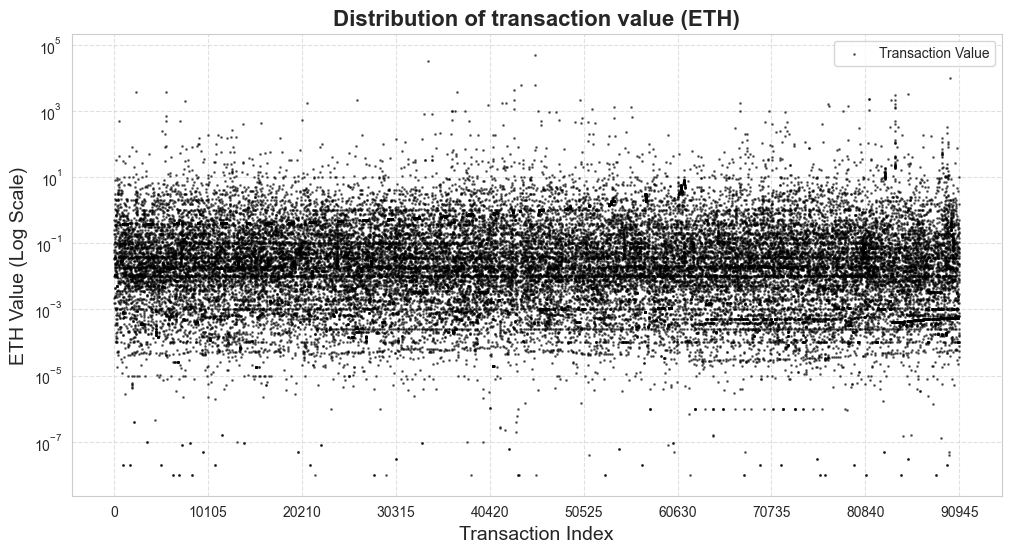

In [26]:
plot_log_scatter(df.index,
                df['value'],
                'Distribution of transaction value (ETH)',
                'Transaction Index',
                'ETH Value (Log Scale)')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


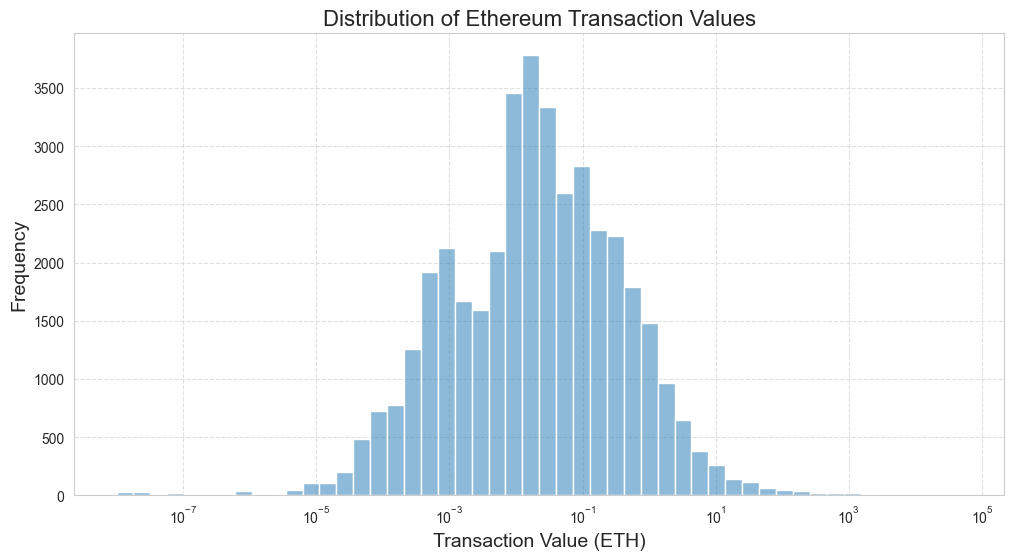

In [27]:
plt.figure(figsize=(12, 6))

sns.histplot(df['value'], bins=50, log_scale=True, kde=True)

plt.xlabel("Transaction Value (ETH)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Ethereum Transaction Values", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


The values of these transactions in ETH is actually fairly normal, and the mass seems to lean a bit heavier on the right side than the left side. We can see that there are actually just as many outliers on the left (possibly more) than there are on the right.

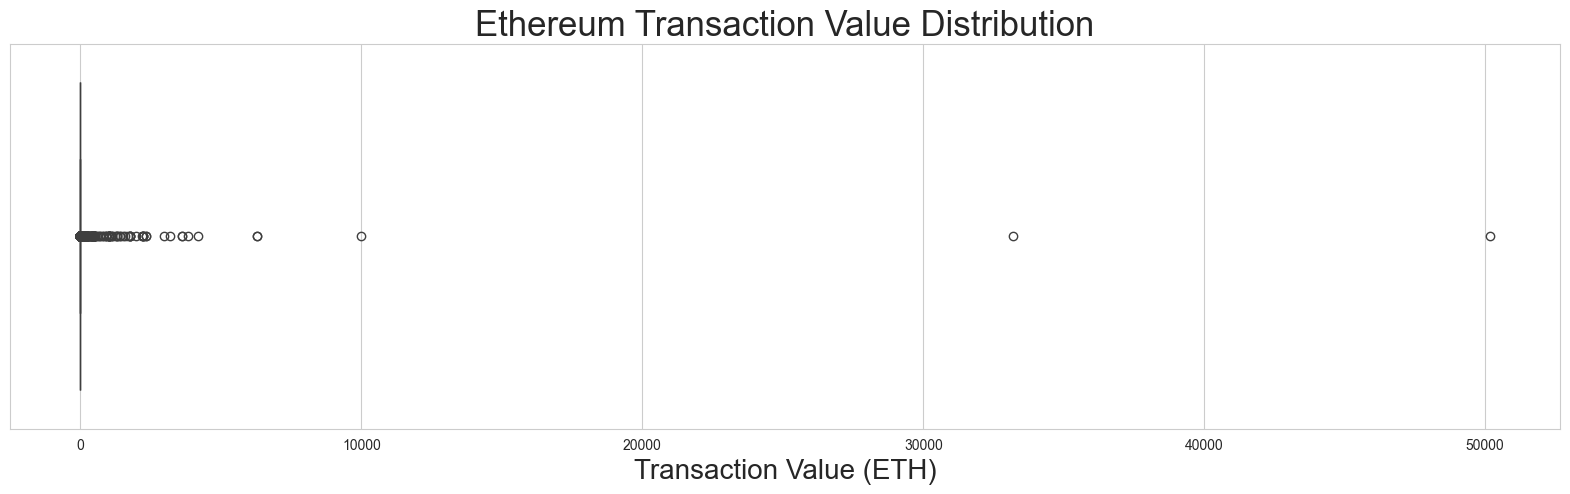

In [28]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=df['value'], showfliers=True)

plt.xlabel("Transaction Value (ETH)", fontsize=20)
plt.title("Ethereum Transaction Value Distribution", fontsize=25)
plt.show()

Lets fine out where our outliers are (for the larger transactions)

In [29]:
def find_outliers(data, threshhold):
    zscores = stats.zscore(data)
    return np.where(zscores >= threshhold)[0]

outliers_gt_2 = find_outliers(df['value'], 2)
outliers_gt_3 = find_outliers(df['value'], 3)

outliers_gt_2_val = df['value'][outliers_gt_2].sort_values()
outliers_gt_3_val = df['value'][outliers_gt_3].sort_values()

In [30]:
print(f'Number of transactions with a Z-score of 2 or higher: {len(outliers_gt_2_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 2:\n {outliers_gt_2_val}')

Number of transactions with a Z-score of 2 or higher: 68
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 2:
 51776      422.000000
50287      428.396932
15794      442.300700
49561      448.000000
72399      450.403953
             ...     
43811     6291.495993
45329     6291.545993
89901    10000.000000
33744    33183.511741
45248    50156.239046
Name: value, Length: 68, dtype: float64


In [31]:
print(f'Number of transactions with a Z-score of 3 or higher: {len(outliers_gt_3_val)}')
print('--------------------------------------------------------------------------------')
print(f'Values that are greater than a Z-score of 3:\n {outliers_gt_3_val}')

Number of transactions with a Z-score of 3 or higher: 50
--------------------------------------------------------------------------------
Values that are greater than a Z-score of 3:
 55726      677.950000
5556       681.964490
34229      799.999300
33347      800.760000
46828      898.004042
47505      898.004078
72142      921.531963
36324      998.819958
78462      999.000000
37817      999.998500
36658     1000.000000
67298     1006.392021
70419     1006.393500
36320     1012.747727
45630     1012.748200
81187     1086.320588
43008     1109.007218
51449     1109.007556
84033     1239.999943
53744     1289.999929
55611     1290.000000
84014     1291.999895
76901     1421.055533
78981     1421.055592
40255     1520.615121
84028     1578.168782
76816     1677.999840
41773     1749.462023
42161     1749.462143
20759     1775.000000
67301     1778.999099
7625      1963.000000
26178     2204.000000
43011     2218.109828
50175     2218.110000
83554     2218.114564
84049     2218.114600
81

Having the z-score on hand in our data can be a useful feature, so lets add a column that displays it.

In [32]:
df['value_zscore'] = stats.zscore(df['value'])
df.head()

id,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.0,223837,180.411926,2025-02-14 10:16:10,-0.012148
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.0,153985,81.237520,2025-02-14 10:16:10,-0.012148
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.0,223550,65.091946,2025-02-14 10:16:11,-0.012148
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.0,500002,63.063619,2025-02-14 10:16:11,-0.012148
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.0,252997,47.995919,2025-02-14 10:16:11,-0.012148


Something else that might be useful is detecting transaction patterns between senders and recipients. Frequent interaction between ids can possibly be suspicious activity.

Lets integrate a SQL query to conduct this analysis.

In [36]:
# Open another connection
db_password = os.environ.get('DB_PASSWORD')

# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=db_password,  # Use your MySQL password
    database="blockchain_fraud"
)

query = '''SELECT sender, recipient, COUNT(*) AS num_transactions
           FROM transactions
           GROUP BY sender, recipient
           HAVING COUNT(*) > 50'''

df_wash_trading = pd.read_sql(query, conn)

conn.close()

/var/folders/cj/bg2z73t51ts_ftlnkpg413qm0000gn/T/ipykernel_70748/3046172086.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_wash_trading = pd.read_sql(query, conn)


In [39]:
df_wash_trading.describe()

,num_transactions
count,60.000000
mean,120.250000
std,70.973049
min,51.000000
25%,66.000000
50%,109.500000
75%,141.000000
max,452.000000
